In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from skbio.stats.ordination import pcoa
#from skbio import TreeNode
#from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac
from scipy.spatial.distance import braycurtis, pdist, squareform
from torchmetrics.regression import MeanSquaredError, MeanAbsolutePercentageError
import warnings
from collections import Counter
import scipy.stats
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import NMF


In [2]:
%cd /home/zuzannak/MicroFormer/

/home/zuzannak/MicroFormer


/home/zuzannak/MicroFormer/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [81]:
pathways = pd.read_csv('inputs/pathways_relab.csv', index_col= [0], low_memory=False).fillna(0).sort_index()
metadata = pd.read_csv('inputs/metadata.csv', index_col= [0], low_memory=False).sort_index()

metadata = metadata[metadata['sample_id'].isin(pathways.index)]
#metadata = metadata[metadata.study_condition.isin(['control', 'IBD'])]
metadata['SICK'] = np.where(metadata.disease == 'healthy', 0, 1)

#get only a small group
keep_samples_H_kids = metadata[(metadata['SICK'] == 0) & (metadata['age'] < 5)].drop_duplicates('sample_id', keep='first').sample(100, random_state=32).sample_id.tolist()
keep_samples_H = metadata[(metadata['SICK'] == 0) & (metadata['age'] > 5) ].drop_duplicates('sample_id', keep='first').sample(3000, random_state=32).sample_id.tolist()
keep_samples_S = metadata[(metadata['age'] > 5) & (metadata['SICK'] == 1)].drop_duplicates('sample_id', keep='first').sample(2000, random_state=32).sample_id.tolist()

keep_samples = keep_samples_H + keep_samples_S 

pathways = pathways.loc[keep_samples].iloc[:, 2:].dropna()

In [ ]:
## Filter low abundance bacteria
def filter_prevalence(df, treshold = 0.1):
    '''features as columns'''
    df_binary = df.copy()
    df_binary[df_binary>0]=1
    df_binary_sum = df_binary.sum(axis=0)
    
    keep_features = df_binary_sum[df_binary_sum > df.shape[0]*treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

def filter_on_abundance(df, abundance_treshold = 1e-3):
    '''features as columns'''
    df_relab = df.div(df.sum(axis=1), axis=0)
    df_relab_mean = df_relab.mean()

    keep_features = df_relab_mean[df_relab_mean > abundance_treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

filtered_pathways = filter_prevalence(pathways)
filtered_pathways = filtered_pathways.div(filtered_pathways.sum(axis=1), axis=0).dropna()

# NMF

In [31]:
def evaluate_nmf_generalization_direct(X_train, X_test, n_components, random_state=42):
    """
    Evaluate NMF generalization when using fit_transform directly.
    
    Parameters:
    -----------
    X_train : training data matrix
    X_test : test data matrix
    n_components : number of components for NMF
    random_state : random seed for reproducibility
    
    Returns:
    --------
    dict containing evaluation metrics
    """
    # Fit NMF on training data
    nmf_model = NMF(
        n_components=n_components,
        init='random',
        random_state=random_state,
        max_iter=5000
    )
    
    # Get W and H matrices for training data
    W_train = nmf_model.fit_transform(X_train * 100)
    H_train = nmf_model.components_
    
    # Transform test data
    W_test = nmf_model.transform(X_test * 100)
    
    # Normalize matrices
    H_train = H_train / H_train.sum(axis=1)[:, np.newaxis]
    
    # Calculate reconstruction error
    train_reconstruction = np.dot(W_train, H_train)
    test_reconstruction = np.dot(W_test, H_train)
    
    train_error = mean_squared_error(X_train * 100, train_reconstruction)
    test_error = mean_squared_error(X_test * 100, test_reconstruction)
    
    # Get dominant patterns
    dominant_patterns_train = np.argmax(W_train, axis=1)
    dominant_patterns_test = np.argmax(W_test, axis=1)
    
    # Calculate pattern correlations
    pattern_correlations = []
    for i in range(n_components):
        train_pattern = H_train[i, :]
        test_pattern = np.average(X_test, weights=W_test[:, i], axis=0)
        corr, _ = spearmanr(train_pattern, test_pattern)
        pattern_correlations.append(corr)
    
    return {
        'train_reconstruction_error': train_error,
        'test_reconstruction_error': test_error,
        'pattern_correlations': np.mean(pattern_correlations),
        'W_train': W_train,
        'W_test': W_test,
        'H': H_train,
        'dominant_patterns_train': dominant_patterns_train,
        'dominant_patterns_test': dominant_patterns_test,
        'n_components':n_components
    }

In [17]:
## Run Kfold NMF
data = filtered_pathways.values.copy()

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
NMF_res = pd.DataFrame()

for n_components in range(2, 8):
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data)):
        # Split data
        X_train = data[train_idx]
        X_test = data[test_idx]

        results = evaluate_nmf_generalization_direct(X_train, X_test, n_components)
        df = pd.DataFrame({k: [v] for k, v in results.items()})
        df['fold'] = fold_idx
        NMF_res = pd.concat([NMF_res, df])

<Axes: xlabel='n_components', ylabel='train_reconstruction_error'>

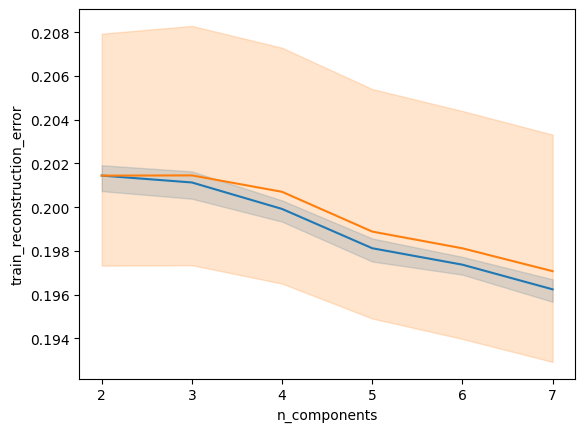

In [18]:
sns.lineplot(x = NMF_res.n_components, y = NMF_res.train_reconstruction_error)
sns.lineplot(x = NMF_res.n_components, y = NMF_res.test_reconstruction_error)

<Axes: xlabel='n_components', ylabel='pattern_correlations'>

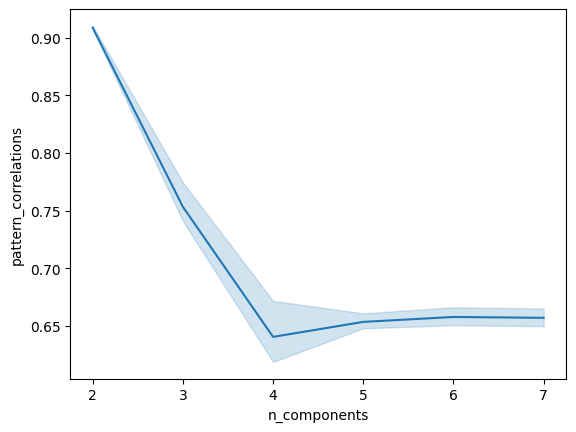

In [19]:
sns.lineplot(x = NMF_res.n_components, y = NMF_res.pattern_correlations)

In [23]:
NMF_res.groupby(by = ['n_components']).median()

,train_reconstruction_error,test_reconstruction_error,pattern_correlations,fold
n_components,,,,
2,0.201797,0.198150,0.908123,4.5
3,0.201523,0.198267,0.745337,4.5
4,0.200231,0.197499,0.624638,4.5
5,0.198486,0.195757,0.649211,4.5
6,0.197630,0.194869,0.654536,4.5
7,0.196489,0.194227,0.654424,4.5


In [32]:
### Run NMF on 3 components

X_train_pathways, X_test_pathways = train_test_split(filtered_pathways, test_size=0.2, random_state=0)
res = evaluate_nmf_generalization_direct(X_train_pathways, X_test_pathways, 3)

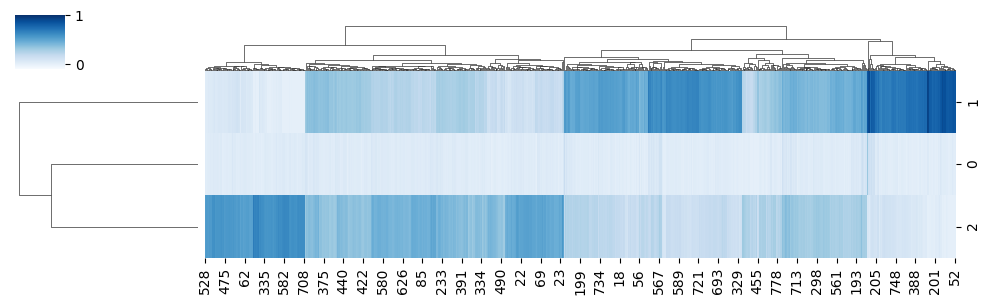

In [44]:
sns.clustermap(res['W_test'].T, figsize = (10, 3), cmap = 'Blues', vmax = 0, vmin=1)

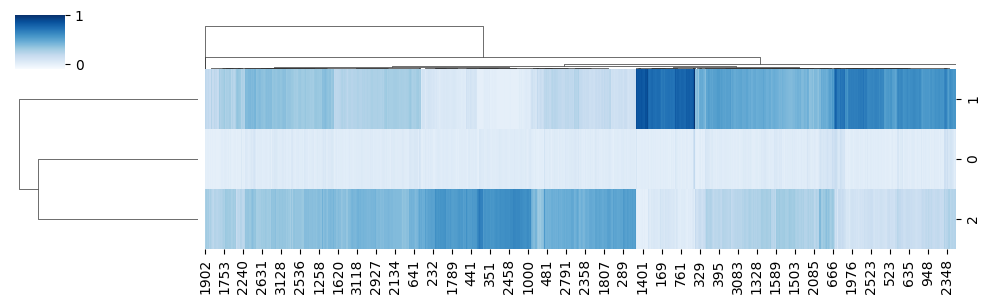

In [45]:
sns.clustermap(res['W_train'].T, figsize = (10, 3), cmap = 'Blues', vmax = 0, vmin=1)

In [67]:
H_df = pd.DataFrame(res['H'], columns = filtered_pathways.columns).T
H_df.sort_values(by = [0], ascending=False).head(10)[0].index

Index(['PWY-7221: guanosine ribonucleotides de novo biosynthesis',
       'PWY-5695: urate biosynthesis/inosine 5'-phosphate degradation',
       'PWY-3781: aerobic respiration I (cytochrome c)',
       'PWY-6527: stachyose degradation',
       'PWY-6317: galactose degradation I (Leloir pathway)',
       'PWY66-422: D-galactose degradation V (Leloir pathway)',
       'PWY-6609: adenine and adenosine salvage III',
       'CITRULBIO-PWY: L-citrulline biosynthesis',
       'DTDPRHAMSYN-PWY: dTDP-L-rhamnose biosynthesis I',
       'PWY-7219: adenosine ribonucleotides de novo biosynthesis'],
      dtype='object')

In [66]:
H_df.sort_values(by = [1], ascending=False).head(10)[1].index

Index(['DTDPRHAMSYN-PWY: dTDP-L-rhamnose biosynthesis I',
       'PWY-7219: adenosine ribonucleotides de novo biosynthesis',
       'PWY-1042: glycolysis IV (plant cytosol)',
       'PWY-6609: adenine and adenosine salvage III',
       'PWY-5686: UMP biosynthesis', 'VALSYN-PWY: L-valine biosynthesis',
       'PWY-6700: queuosine biosynthesis',
       'ILEUSYN-PWY: L-isoleucine biosynthesis I (from threonine)',
       'PWY-7111: pyruvate fermentation to isobutanol (engineered)',
       'PWY-6385: peptidoglycan biosynthesis III (mycobacteria)'],
      dtype='object')

In [68]:
H_df.sort_values(by = [2], ascending=False).head(10)[2].index

Index(['PWY-6737: starch degradation V',
       'PWY-1042: glycolysis IV (plant cytosol)',
       'ARGSYNBSUB-PWY: L-arginine biosynthesis II (acetyl cycle)',
       'PWY-7111: pyruvate fermentation to isobutanol (engineered)',
       'ILEUSYN-PWY: L-isoleucine biosynthesis I (from threonine)',
       'VALSYN-PWY: L-valine biosynthesis',
       'ARGSYN-PWY: L-arginine biosynthesis I (via L-ornithine)',
       'PWY-7400: L-arginine biosynthesis IV (archaebacteria)',
       'PWY-5686: UMP biosynthesis',
       'PWY-7219: adenosine ribonucleotides de novo biosynthesis'],
      dtype='object')

In [72]:
def plot_pcoa(x):
    
    dm = squareform(pdist((np.log(x+1e-5))))
    pcoa_df = pcoa(dm).samples
    return pcoa_df

<Axes: xlabel='PC1', ylabel='PC2'>

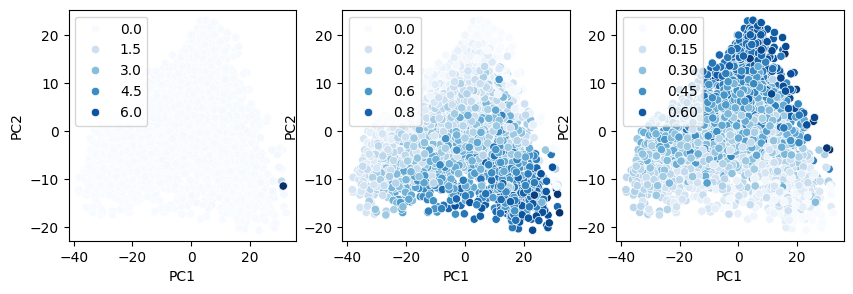

In [76]:
pcoa_df = plot_pcoa(X_train_pathways)

fig, axes = plt.subplots(1, 3, figsize = (10, 3))

sns.scatterplot(x = pcoa_df.PC1, y=pcoa_df.PC2, hue = res['W_train'][:, 0], palette = 'Blues', ax=axes[0])
sns.scatterplot(x = pcoa_df.PC1, y=pcoa_df.PC2, hue = res['W_train'][:, 1], palette = 'Blues', ax=axes[1])
sns.scatterplot(x = pcoa_df.PC1, y=pcoa_df.PC2, hue = res['W_train'][:, 2], palette = 'Blues', ax=axes[2])

<Axes: xlabel='PC1', ylabel='PC2'>

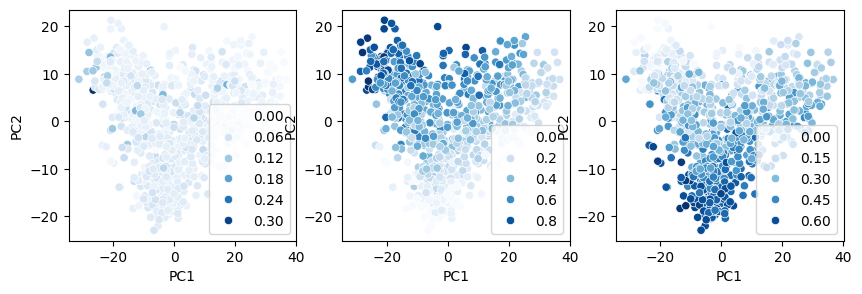

In [79]:
pcoa_df = plot_pcoa(X_test_pathways)

fig, axes = plt.subplots(1, 3, figsize = (10, 3))

sns.scatterplot(x = pcoa_df.PC1, y=pcoa_df.PC2, hue = res['W_test'][:, 0], palette = 'Blues', ax=axes[0])
sns.scatterplot(x = pcoa_df.PC1, y=pcoa_df.PC2, hue = res['W_test'][:, 1], palette = 'Blues', ax=axes[1])
sns.scatterplot(x = pcoa_df.PC1, y=pcoa_df.PC2, hue = res['W_test'][:, 2], palette = 'Blues', ax=axes[2])